# Table of Contents
 <p><div class="lev1 toc-item"><a href="#COPA-Preprocess" data-toc-modified-id="COPA-Preprocess-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>COPA Preprocess</a></div><div class="lev1 toc-item"><a href="#CausalNet-Preprocess" data-toc-modified-id="CausalNet-Preprocess-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>CausalNet Preprocess</a></div><div class="lev1 toc-item"><a href="#Compute-CausalPMI" data-toc-modified-id="Compute-CausalPMI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compute CausalPMI</a></div><div class="lev1 toc-item"><a href="#Experiment" data-toc-modified-id="Experiment-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Experiment</a></div><div class="lev2 toc-item"><a href="#Decison" data-toc-modified-id="Decison-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Decison</a></div><div class="lev3 toc-item"><a href="#mini" data-toc-modified-id="mini-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>mini</a></div><div class="lev1 toc-item"><a href="#Build-Dataset" data-toc-modified-id="Build-Dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Dataset</a></div>

# COPA Preprocess

In [261]:
import json
import os
import spacy
from spacy.parts_of_speech import NOUN, VERB, ADJ, ADV, NUM, PROPN
from nltk.corpus import stopwords
from itertools import product
import pickle

nlp = spacy.load('en')
stopWords = stopwords.words('english')
DEV_DATA_DIR = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-dev.json'
TEST_DATA_DIR = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-test.json'

def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

def isNoise(token):
    """
    Check if the token is a noise or not 
    """
    is_noise = False
    if token.pos not in [NOUN, VERB, ADJ, ADV, NUM, PROPN]:
        is_noise = True
    return is_noise

def del_stop(s):
    """
    Delete stop words
    """
    return [w for w in s if w not in stopWords and '-' not in w]

def clean(token):
    """
    Clean data
    """
    return token.lemma_

def prune(c, e):
    """
    Prune the redundant pairs
    """
    cw = [i[0] for i in c+e]
    ew = [i[1] for i in c+e]
    for i in range(len(c)):
        try:
            if c[i][1] in cw:
                c[i] = None
        except:
            continue
        try:
            if c[i][0] in ew:
                c[i] = None
        except:
            continue
        
    for i in range(len(e)):
        try:
            if e[i][1] in cw:
                e[i] = None
        except:
            continue
        try:
            if e[i][0] in ew:
                e[i] = None
        except:
            continue
            
    for p1 in c:
        for p2 in e:
            if p1 == p2 and p1 != None and p2 != None:
                c[c.index(p1)] = None
                e[e.index(p2)] = None
        
    c = [p for p in c if p != None]
    e = [p for p in e if p != None]
    return c, e

class Data:
    def __init__(self, path):
        self.premise = load_data(path, 'premise')
        self.ask_for = load_data(path, 'asks-for')
        self.alternative1 = load_data(path, 'alternative1')
        self.alternative2 = load_data(path, 'alternative2')
        self.label = load_data(path, 'most-plausible-alternative')
        
    def clean(self):
        premise = [del_stop(s) for s in [[clean(i) for i in j if not isNoise(i)] for j in [nlp(i) for i in self.premise]]]
        alternative1 = [del_stop(s) for s in [[clean(i) for i in j if not isNoise(i)] for j in [nlp(i) for i in self.alternative1]]]
        alternative2 = [del_stop(s) for s in [[clean(i) for i in j if not isNoise(i)] for j in [nlp(i) for i in self.alternative2]]]
        return premise, alternative1, alternative2
    
    def pair(self):
        p, a1, a2 = self.clean()
        label = [int(l) for l in self.label]
        cp1, cp2, c, e = [], [], [], []
        for i in range(500):
            if self.ask_for[i] == 'cause':
                cp1.append([cp for cp in product(a1[i], p[i])])
                cp2.append([cp for cp in product(a2[i], p[i])])
                c.append(a1[i]), c.append(a2[i]), e.append(p[i])
            else:
                cp1.append([cp for cp in product(p[i], a1[i])])
                cp2.append([cp for cp in product(p[i], a2[i])])
                c.append(p[i]), e.append(a1[i]), e.append(a2[i])
            cp1[-1], cp2[-1] = prune(cp1[-1], cp2[-1])
        return cp1, cp2, c, e, label

devData = Data(DEV_DATA_DIR)
testData = Data(TEST_DATA_DIR)

devcp1, devcp2, devCwords, devEwords, devLabel  = devData.pair()
testcp1, testcp2, testCwords, testEwords, testLabel  = testData.pair()

copaPair = list(set(sum(devcp1+devcp2+testcp1+testcp2, [])))
copaCword = list(set(sum(devCwords+testCwords, [])))
copaEword = list(set(sum(devEwords+testEwords, [])))
copaWord = list(set(sum(sum(devData.clean(), []), []) + sum(sum(testData.clean(), []), [])))

In [294]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/copa.pkl', 'wb') as fp:
    pickle.dump((copaPair, copaCword, copaEword, copaWord, devcp1, devcp2, devLabel, testcp1, testcp2, testLabel), fp, -1)

# CausalNet Preprocess

In [1]:
import pickle
from tqdm import tqdm

In [2]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/copa.pkl', 'rb') as fp:
    copaPair, copaCword, copaEword, copaWord, devcp1, devcp2, devLabel, testcp1, testcp2, testLabel = pickle.load(fp)

In [3]:
filename = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/CausalNet/CausalNet.txt'
raw_text = [i.split() for i in tqdm(open(filename).read().split('\n'))]

100%|██████████| 62675002/62675002 [04:33<00:00, 228780.77it/s]


In [4]:
causalPairs = []
for i in tqdm(range(len(raw_text))):
    if raw_text[i][0] in copaCword or raw_text[i][1] in copaEword:
        causalPairs.append(raw_text[i])

100%|██████████| 62675002/62675002 [40:37<00:00, 25713.32it/s]


In [5]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/causalPairs.pkl', 'wb') as fp:
    pickle.dump((causalPairs), fp, -1)

In [6]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/causalPairs.pkl', 'rb') as fp:
    causalPairs = pickle.load(fp)

In [7]:
causalPair = []
causalFreq = []
for i in tqdm(range(len(causalPairs))):
    causalPair.append(tuple(causalPairs[i][:2]))
    causalFreq.append(int(causalPairs[i][-1]))

100%|██████████| 24390169/24390169 [00:28<00:00, 865338.51it/s]


In [8]:
copaPair_freq = {cp: 0 for cp in copaPair}
copaCword_freq = {cw: 0 for cw in copaCword}
copaEword_freq = {cw: 0 for cw in copaEword}

In [9]:
for cp in tqdm(copaPair):
    try:
        copaPair_freq[cp] = causalFreq[causalPair.index(cp)]
    except:
        pass

100%|██████████| 15386/15386 [1:42:47<00:00,  2.49it/s]


In [10]:
for cw in tqdm(copaCword):
    freq = []
    for i in range(len(causalPairs)):
        if cw == causalPairs[i][0]:
            freq.append(causalFreq[i])
    copaCword_freq[cw] = sum(freq)

100%|██████████| 1926/1926 [1:27:00<00:00,  2.71s/it]


In [11]:
for cw in tqdm(copaEword):
    freq = []
    for i in range(len(causalPairs)):
        if cw == causalPairs[i][1]:
            freq.append(causalFreq[i])
    copaEword_freq[cw] = sum(freq)

100%|██████████| 1813/1813 [1:27:35<00:00,  2.90s/it]


In [12]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/freq.pkl', 'wb') as fp:
    pickle.dump((copaPair_freq, copaCword_freq, copaEword_freq), fp, -1)

# Compute CausalPMI

In [1]:
import pickle
from tqdm import tqdm

In [2]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/causalPairs.pkl', 'rb') as fp:
    causalPairs = pickle.load(fp)
    
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/copa.pkl', 'rb') as fp:
    copaPair, copaCword, copaEword, copaWord, devcp1, devcp2, devLabel, testcp1, testcp2, testLabel = pickle.load(fp)

with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/freq.pkl', 'rb') as fp:
    copaPair_freq, copaCword_freq, copaEword_freq = pickle.load(fp)

In [3]:
M = 660412209
N = 62675002
ALPHA = 0.66

def CPMI(pairs, LAMBDA=1., length=None, sp_score=False):
    """
    Compute causal-PMI score
    """
    score = []
    if length == None:
        length = len(pairs)
    for p in pairs:
        try:
            CSnec = (copaPair_freq[p] / N) / (((copaCword_freq[p[0]] / M) ** ALPHA) * (copaEword_freq[p[1]]) / M)
        except:
            CSnec = 0
        try:
            CSsuf = (copaPair_freq[p] / N) / ((copaCword_freq[p[0]] / M) * ((copaEword_freq[p[1]] / M) ** ALPHA))
        except:
            CSsuf = 0
        CS = (CSnec ** LAMBDA) * (CSsuf ** (1 - LAMBDA))
        score.append(CS)
    if not sp_score:
        try:
            return sum(score) / length
        except:
            return 0
    else:
        return score

def accuracy(a1, a2, actu, LAMBDA=1., length_mode=2016, show=True):
    """
    Calculate Accuracy
    """
    if length_mode == 2016:
        l1 = [len(set([i[0] for i in a1[n]]+[i[-1] for i in a1[n]])) for n in range(500)]
        l2 = [len(set([i[0] for i in a2[n]]+[i[-1] for i in a2[n]])) for n in range(500)]
        A1 = [CPMI(a1[i], LAMBDA=LAMBDA, length=l1[i]) for i in range(500)]
        A2 = [CPMI(a2[i], LAMBDA=LAMBDA, length=l2[i]) for i in range(500)]
    elif length_mode == 2017:
        A1 = [CPMI(p, LAMBDA=LAMBDA) for p in a1]
        A2 = [CPMI(p, LAMBDA=LAMBDA) for p in a2]
    pred = []
    for i in range(500):
        if A1[i] >= A2[i]:
            pred.append(1)
        elif A1[i] < A2[i]:
            pred.append(2)
        else:
            pred.append(0)
    S = sum([1 for i in range(len(pred)) if pred[i] == actu[i]])
    ACC = S / len(actu)
    print('Accuracy: \t%.9f' % (ACC))
    if show:
        error = []
        l1 = [len(set([i[0] for i in a1[n]]))+len(set([i[-1] for i in a1[n]])) for n in range(500)]
        l2 = [len(set([i[0] for i in a2[n]]))+len(set([i[-1] for i in a2[n]])) for n in range(500)]
        for i in range(500):
            s1 = []
            s2 = []
            print('————————————————————————————————————')
            print(str(i+1)+':')
            for p in a1[i]:
                print(p[0], p[1], CPMI([p], sp_score=True)[0])
                s1.append(CPMI([p], sp_score=True))
            print('------------------')
            for p in a2[i]:
                print(p[0], p[1], CPMI([p], sp_score=True)[0])
                s2.append(CPMI([p], sp_score=True))
            if length_mode == 2016:
                try:
                    S1 = sum(sum(s1, []))/l1[i]
                except:
                    S1 = 0
                try:
                    S2 = sum(sum(s2, []))/l2[i]
                except:
                    S2 = 0
            elif length_mode == 2017:
                S1 = sum(sum(s1, []))/len(a1[i])
                S2 = sum(sum(s2, []))/len(a2[i])
            print('S1:------'+str(S1))
            print('S2:------'+str(S2))
            if S1 >= S2:
                pre = '1'
            elif S1 < S2:
                pre = '2'
            else:
                pre = '0'
            print('Predict Answer: '+pre)
            print('Correct Answer: '+str(actu[i]))
            if pre != str(actu[i]):
                error.append(i+1)
        return pred, error
    else:
        return pred

In [8]:
accuracy(devcp1, devcp2, devLabel, LAMBDA=1., length_mode=2016, show=False);

Accuracy: 	0.600000000


In [9]:
DP, DE = accuracy(devcp1, devcp2, devLabel, LAMBDA=1., length_mode=2016, show=True)

Accuracy: 	0.600000000
————————————————————————————————————
1:
sun body 1.7789488353585174
sun cast 2.6442464419302425
sun shadow 29.85059122297761
rise body 0.5977254771821533
rise cast 0.44306425003525163
rise shadow 1.2066934398285478
------------------
cut body 0.5348654228571027
cut cast 0.7643037402339852
cut shadow 0.5175857735837327
S1:------7.304253933462464
S2:------0.4541887341687051
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
2:
know tolerate 1.7833558536661094
know difficult 1.1567982743853666
know behavior 1.4442585017471863
go tolerate 0.0
go difficult 0.0
go behavior 0.0
hard tolerate 0.7038660012054978
hard difficult 1.8542954799805618
hard behavior 0.47546931705998824
time tolerate 1.1957661859324555
time difficult 2.1601485384437793
time behavior 1.2399242349242081
------------------
feel tolerate 1.0867346694422202
feel difficult 0.7694124852792259
feel behavior 0.8777298909694916
take tolerate 1.2011215851650527
take difficult 1.2479751

woman door 0.7440673844622269
date open 0.6987223869012344
date door 0.35471699931521755
want open 0.0
want door 0.0
look open 1.0959947083280641
look door 1.8792465129961191
gentleman open 0.19091878727760195
gentleman door 0.4518608391482395
------------------
woman ask 1.2536558899073025
woman like 1.3682294018921082
woman sushi 0.4377215842512633
date ask 0.9161740795587794
date like 0.7105311220583534
date sushi 0.20687477911478122
want ask 0.0
want like 0.0
want sushi 0.0
look ask 1.581763112045339
look like 3.5476410857345027
look sushi 2.543646096859491
gentleman ask 0.7125331779917227
gentleman like 0.4168556442572989
gentleman sushi 0.0
S1:------0.8630012905648956
S2:------1.7119532467088676
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
23:
farmland canal 0.0
farmland construct 1.3671185744133123
need canal 0.0
need construct 0.0
irrigation canal 8.749364919441472
irrigation construct 0.5307768604354669
------------------
farmland flood 1.3668892014

cook together 0.0
stir blend 0.5070003566495599
stir together 0.0
bowl blend 1.8436222151998276
bowl together 0.0
S1:------0.8959115904066581
S2:------0.7802568316682517
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
55:
man void 0.963320755460334
sign void 2.381072031454229
document void 0.6333525980693275
------------------
man become 0.0
man official 0.6594115585143797
sign become 0.0
sign official 1.2602608330488756
document become 0.0
document official 1.9006059077563606
S1:------0.9944363462459727
S2:------0.7640556598639232
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
56:
police recoil 0.0
officer recoil 0.0
drop recoil 0.0
------------------
police go 0.0
officer go 0.0
drop go 0.0
S1:------0.0
S2:------0.0
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
57:
woman donate 0.8091065788617959
woman blood 1.177248839279673
feel donate 3.79710277425272
feel blood 0.4470974797919182
compel donate 0.8503262

go shoe 0.0
numb put 0.5628808834472094
numb shoe 0.8756759442168881
------------------
go shake 0.0
numb shake 1.2987873188548662
S1:------0.35963920691602436
S2:------0.4329291062849554
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
92:
get snap 0.0
get photo 0.0
smile snap 0.8085416271442564
smile photo 0.8226730703776454
------------------
get change 0.0
get pose 0.0
smile change 0.13051327111447053
smile pose 0.756273386850043
S1:------0.40780367438047543
S2:------0.22169666449112838
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
93:
glass window 11.859242610763705
glass opaque 36.71296231431663
stain window 1.4017574684919039
stain opaque 5.410073055361017
------------------
blind window 1.397937306425135
blind opaque 1.416955134722736
open window 5.04529140014939
open opaque 2.6164285799270783
S1:------13.846008862233312
S2:------2.6191531053060846
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
94:
wet

tattered young 0.0
tattered sister 0.0
------------------
outgrow girl 0.3369364867892035
outgrow hand 0.2827726139220619
outgrow young 0.4110986667146926
outgrow sister 0.0
S1:------0.0
S2:------0.20616155348519158
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
127:
several acquit 0.0
witness acquit 17.17972313696221
crime acquit 8.953143841427599
testify acquit 28.27274797658779
------------------
several convict 0.0
witness convict 6.993947010471248
crime convict 21.28602588833342
testify convict 6.330483604812938
S1:------10.881122990995518
S2:------6.922091300723521
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
128:
young parent 4.440621131328557
young leave 1.0416205359320945
young babysitter 12.917870047915253
start parent 0.9846072742256138
start leave 1.3521111235662675
start babysitter 0.48945238305622696
attend parent 2.158303344071015
attend leave 0.8974243303692405
attend babysitter 2.1429344694590315
preschool parent 3.

smell wipe 4.181892253227328
smell mouth 4.626006158520772
garlic wipe 0.0
garlic mouth 3.4672941893222027
------------------
breath brush 4.601092176227091
breath tooth 7.134463476151773
smell brush 1.3031901021863845
smell tooth 0.5857186637637135
garlic brush 3.139617463476569
garlic tooth 1.0583255710457211
S1:------5.454091155456297
S2:------3.5644814905702504
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
164:
man ask 1.6996215492544742
man direction 0.6869740266104527
lose ask 0.6776143583712939
lose direction 0.8068668155349141
------------------
man draw 1.3909758391924016
man map 0.2510065645117375
lose draw 0.853312938770574
lose map 0.4782219942907221
S1:------0.9677691874427837
S2:------0.7433793341913588
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
165:
pull burp 1.7810168835239626
hair burp 0.0
------------------
pull grimace 4.546126018781609
hair grimace 0.0
S1:------0.5936722945079875
S2:------1.5153753395938698
Pr

door woman 0.3954904559719051
door feel 0.36704367722368897
door electric 3.880840041639556
door shock 0.3401713966240752
S1:------0.6359315832704379
S2:------1.0789193781466904
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
201:
kiss man 1.1475897868858866
kiss lipstick 12.593448051941246
kiss cheek 14.011651712386682
------------------
make man 1.7544013710546253
make lipstick 6.179005676563682
make cheek 1.5988024941626382
blush man 0.052408296386573884
blush lipstick 23.49773578317799
blush cheek 26.14391931944515
S1:------6.938172387803453
S2:------11.845254588158133
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
202:
sense jump 0.7909531443749745
sense instinctively 0.0
sense fright 0.0
someone jump 0.0
someone instinctively 0.0
someone fright 0.0
approach jump 0.4646928985734423
approach instinctively 0.0
approach fright 2.7683856022465436
behind jump 0.0
behind instinctively 0.0
behind fright 0.0
------------------
hear jump 0

hole man 0.31537886897820955
hole break 0.8871059295221148
hole toe 1.4810868514969846
sock man 0.438432452412607
sock break 0.4657182820987015
sock toe 26.242312827881094
------------------
drop man 0.4371500424718172
drop break 1.1866877125079816
drop toe 2.352746348929053
hammer man 0.21194949089599818
hammer break 0.799578658952642
hammer toe 10.171076630641089
foot man 0.7369040947693483
foot break 1.1712152426188762
foot toe 79.65040527143596
S1:------4.971672535398285
S2:------16.119618915537128
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
238:
man manipulate 1.5415232185745669
man friend 1.844350445574947
attack manipulate 0.9056269283685052
attack friend 0.6441334401725558
conscience manipulate 1.0772216114018136
conscience friend 0.2480443218733598
------------------
man admit 1.7794057406057409
man indiscretion 9.44338977233712
attack admit 1.7336320698909755
attack indiscretion 0.0
conscience admit 0.46397564109073347
conscience indiscretion 0.0


whiff man 0.0
whiff take 0.12205643286269813
whiff notice 0.0
whiff woman 0.35567449112254707
perfume man 0.40978609554131723
perfume take 0.2264743561842031
perfume notice 0.24523002778460287
perfume woman 0.9899251047104002
------------------
back man 1.320854564112359
back take 1.5317014613135131
back notice 1.5747182104365485
back woman 0.9077057926852212
turn man 1.0589034138435496
turn take 1.0230622787955177
turn notice 0.8210473658382461
turn woman 0.8112737866418258
S1:------0.7176409500201365
S2:------1.5082111456111302
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
274:
woman stop 1.1458612382507805
woman see 0.0
boyfriend stop 0.7277496172835053
boyfriend see 0.0
get stop 0.0
get see 0.0
fight stop 1.2381106229779222
fight see 0.0
------------------
woman plan 0.7606242451459283
woman vacation 0.36650338629637363
woman together 0.0
boyfriend plan 0.6451826012739691
boyfriend vacation 0.8602575992570006
boyfriend together 0.0
get plan 0.0
get vacati

————————————————————————————————————
306:
climb run 0.463925233123652
climb breath 0.39898188724281153
flight run 0.38418154819731226
flight breath 0.14417509299064835
stair run 0.20051126151427343
stair breath 0.6897694354217536
------------------
read run 1.050184453163127
read breath 0.7714985955032403
chapter run 0.21661138471024505
chapter breath 0.0
book run 0.7203349604478875
book breath 0.40654534734097664
S1:------0.45630889169809025
S2:------0.6330349482330954
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
307:
woman send 0.40625916839759457
woman psychiatric 0.9365779000671023
woman institution 0.9182450146791612
deem send 0.4539759228763165
deem psychiatric 1.0283812597248971
deem institution 0.617296766345367
mentally send 0.0
mentally psychiatric 0.0
mentally institution 0.0
ill send 0.3043773126190752
ill psychiatric 3.4600311170332105
ill institution 1.1249985514214067
------------------
woman seek 1.3139303439784689
woman career 2.520329483864

chase ground 0.4577991682722611
S1:------0.2013375161710437
S2:------0.3707526702190131
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
337:
boy lift 0.38701747757034355
boy weight 0.18608617622778104
want lift 0.0
want weight 0.0
muscular lift 2.76126247990017
muscular weight 0.9293713187584113
------------------
boy play 1.4581588764453541
boy computer 0.20195501069530641
boy game 1.0151189417583153
want play 0.0
want computer 0.0
want game 0.0
muscular play 0.24520174148217866
muscular computer 0.0
muscular game 0.03200640586283362
S1:------0.8527474904913411
S2:------0.4920734960406646
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
338:
scientist validate 0.0
scientist theory 3.5056816541530056
conduct validate 2.310493127697433
conduct theory 1.1777389895225945
experiment validate 4.269876387552256
experiment theory 3.8746572967910295
------------------
scientist fabricate 0.9081478635701893
scientist data 0.6563339982482318
condu

denial easily 0.0
tragedy get 0.0
tragedy easily 0.0
------------------
man refuse 1.795118099253598
man talk 1.8308500029218249
go refuse 0.0
go talk 0.0
denial refuse 1.502185343958673
denial talk 0.18554778766052485
tragedy refuse 0.2951596331751669
tragedy talk 0.423820718605192
S1:------0.0
S2:------1.0054469309291634
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
375:
wife man 3.494891487434759
wife grieve 2.8287991952263023
criticize man 0.5946437628746759
criticize grieve 1.3470638407312885
------------------
mother man 1.488854248503755
mother grieve 7.803786304266815
pass man 0.725751532061551
pass grieve 1.2950074721963287
away man 1.2055380109939766
away grieve 4.699345457607858
S1:------2.0663495715667564
S2:------3.443656605126057
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
376:
rescue girl 0.4908195446638139
rescue phobia 1.6434823044812683
abandon girl 0.6119126571847495
abandon phobia 0.0
------------------
bite gi

Correct Answer: 1
————————————————————————————————————
410:
man headache 0.2504400719242984
drink headache 3.93229256709083
heavily headache 0.0
party headache 0.22146831038995268
------------------
man runny 0.0
man nose 0.9317102214537593
drink runny 0.7320625627418187
drink nose 0.6243302548580075
heavily runny 0.0
heavily nose 0.0
party runny 0.0
party nose 0.2975291243361372
S1:------0.8808401898810162
S2:------0.43093869389828715
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
411:
roll knock 1.7440393431211887
roll pin 2.3162221103247194
alley knock 0.9384956934345949
alley pin 2.492792934002854
------------------
drop knock 0.9214984384618706
drop pin 1.6945238337233794
foot knock 1.7581640344374843
foot pin 1.3491000275538039
S1:------1.8728875202208393
S2:------1.4308215835441345
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
412:
family community 2.325214073661526
family learn 2.0216927851129673
family man 1.5201713853546042

promise event 0.48198267018942303
would man 0.0
would feel 0.0
would obligated 0.0
would attend 0.0
would event 0.0
S1:------0.9082970352273245
S2:------0.33626718574446995
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
439:
bride guest 4.9902019945048846
bride bring 0.8421452646677566
bride gift 2.120863216316438
get guest 0.0
get bring 0.0
get gift 0.0
cold guest 0.3514225900396173
cold bring 1.2211510364144487
cold gift 0.3404450273693185
foot guest 1.0200871836785022
foot bring 0.6996204289006391
foot gift 0.478042451996024
------------------
bride call 0.2674320782884289
get call 0.0
cold call 0.5089803933424543
foot call 0.7546157907138735
S1:------1.7234255991268042
S2:------0.3062056524689513
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
440:
man hair 1.8941769461977058
man turn 1.503382472471122
man gray 1.723719560290129
grow hair 2.423254326766387
grow turn 0.8784650907090062
grow gray 1.1052597099800956
old hair 1.2860154

------------------
tree current 0.4052547455123688
tree become 0.0
tree strong 0.42355279103825094
land current 0.6616792778341207
land become 0.0
land strong 0.844236454096141
S1:------1.1235825313884598
S2:------0.46694465369617627
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
473:
teacher pass 1.232242842599713
teacher note 1.0800877228209176
assign pass 0.4355333179821631
assign note 0.5682436940106519
homework pass 0.5345522362499281
homework note 0.523075832824265
------------------
teacher groan 1.0881030941861574
assign groan 0.0
homework groan 0.0
S1:------0.8747471292975277
S2:------0.27202577354653934
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
474:
season people 0.4772698267506127
season evacuate 0.3059998411577269
season home 0.6982184467202308
change people 1.1688084429986592
change evacuate 0.33711737747447873
change home 0.7968839783283008
summer people 0.42704013300094734
summer evacuate 0.8904297786526898
summer 

In [41]:
devcp1[478]

[('stay', 'vivid'),
 ('stay', 'dream'),
 ('stay', 'night'),
 ('late', 'vivid'),
 ('late', 'dream'),
 ('late', 'night')]

In [42]:
devcp2[478]

[('stay', 'tired'),
 ('stay', 'morning'),
 ('late', 'tired'),
 ('late', 'morning')]

In [34]:
DE

[3,
 4,
 5,
 15,
 16,
 22,
 24,
 32,
 36,
 37,
 39,
 43,
 46,
 48,
 50,
 52,
 53,
 54,
 55,
 56,
 59,
 61,
 63,
 68,
 70,
 75,
 79,
 80,
 85,
 86,
 96,
 97,
 99,
 101,
 103,
 107,
 108,
 113,
 114,
 118,
 120,
 121,
 122,
 123,
 125,
 127,
 128,
 133,
 140,
 141,
 142,
 150,
 157,
 162,
 163,
 166,
 173,
 174,
 176,
 177,
 179,
 180,
 181,
 184,
 193,
 196,
 197,
 200,
 201,
 202,
 206,
 207,
 208,
 210,
 211,
 213,
 215,
 216,
 218,
 219,
 221,
 222,
 223,
 224,
 226,
 228,
 229,
 230,
 240,
 242,
 252,
 256,
 257,
 259,
 260,
 261,
 265,
 267,
 272,
 273,
 277,
 279,
 282,
 284,
 285,
 286,
 288,
 291,
 292,
 294,
 296,
 297,
 299,
 300,
 301,
 303,
 305,
 306,
 308,
 317,
 318,
 319,
 321,
 326,
 327,
 330,
 332,
 333,
 335,
 336,
 339,
 340,
 343,
 345,
 348,
 349,
 351,
 352,
 353,
 358,
 362,
 363,
 365,
 366,
 367,
 370,
 372,
 379,
 380,
 381,
 383,
 385,
 386,
 394,
 395,
 396,
 397,
 402,
 406,
 412,
 413,
 414,
 416,
 417,
 420,
 423,
 424,
 425,
 428,
 429,
 431,
 437,
 438

In [10]:
[i for i in enumerate(DP) if i[-1] == 0]

[]

In [11]:
TP, TE = accuracy(testcp1, testcp2, testLabel, LAMBDA=1., length_mode=2016, show=True)

Accuracy: 	0.674000000
————————————————————————————————————
1:
fragile item 1.6508021684216547
fragile package 1.0035446146407596
fragile bubble 1.05953673624574
fragile wrap 2.6030157337978963
------------------
small item 0.9342960617120789
small package 1.7768925571956506
small bubble 1.5711777432131535
small wrap 1.2509986403228626
S1:------1.2633798506212102
S2:------1.106673000488749
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
2:
empty retrieve 4.005828928716522
empty ticket 0.486220264988308
empty stub 0.0
pocket retrieve 0.31493144207163165
pocket ticket 0.7310685861509365
pocket stub 0.0
------------------
empty find 0.34042392218081124
empty weapon 0.4279823553226768
pocket find 0.2788589083347815
pocket weapon 0.34320188104960586
S1:------1.1076098443854794
S2:------0.34761676672196884
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
3:
invade disappear 0.45312138604475055
------------------
invade eat 0.29045271590810295


break apart 0.0
link come 0.5347333481942841
link apart 0.0
S1:------0.464133011722217
S2:------0.34498240361028315
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
21:
grow couple 0.9117719885612988
grow decide 1.3726340822196375
grow compromise 0.722289285375096
tired couple 0.0
tired decide 0.0
tired compromise 0.0
argue couple 0.45255058021609235
argue decide 0.32137636774618233
argue compromise 0.7405255675248527
------------------
avoid couple 0.6260739089168744
avoid decide 0.6464974278819106
avoid compromise 0.9247017911691623
discuss couple 0.5171215115910949
discuss decide 0.7238629378851693
discuss compromise 0.598812663134034
problem couple 1.438577427998084
problem decide 1.6244922321191386
problem compromise 0.9362799915986253
S1:------0.7535246452738599
S2:------1.3394033153823486
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
22:
woman hire 1.528808227970987
woman campaign 1.8327729462213225
woman manager 0.4164725374704

complain car 0.45328478991579285
complain gas 0.33218412791199015
complain station 0.504544177263804
go stop 0.0
go car 0.0
go gas 0.0
go station 0.0
bathroom stop 0.18983547228250153
bathroom car 0.1807022776231401
bathroom gas 0.5793612107601963
bathroom station 0.32852354759796776
S1:------1.14706826976672
S2:------0.8009992619939676
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
56:
child leap 0.7162143856888163
sprinkled leap 0.0
------------------
child swim 2.117157600122289
sprinkled swim 0.0
S1:------0.23873812856293877
S2:------0.7057192000407629
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
57:
woman switch 0.2358516249932196
woman party 0.7721199407335071
woman affiliation 3.8842616937755245
political switch 0.32440557111539237
political party 4.511763414836734
political affiliation 5.805272255903104
view switch 1.1156516268517218
view party 1.4791963552719942
view affiliation 0.8912814606831427
change switch 2.1815575820

oppress stag 0.0
oppress revolt 17.452052321440995
------------------
government register 0.9012936286570942
government vote 2.7394074503400376
oppress register 0.0
oppress vote 0.19120412570049405
S1:------5.709716427213452
S2:------0.9579763011744065
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
90:
boy pitch 0.35722317974862383
boy tent 1.2200059277885116
lose pitch 0.7187111955101159
lose tent 1.800023375597789
wood pitch 0.6308139928758196
wood tent 0.8617546164635805
------------------
boy scream 3.091202314151161
boy help 0.5325456801556566
lose scream 1.5381089363100557
lose help 1.0007833466947305
wood scream 1.0565223115170426
wood help 0.5397735048102253
S1:------1.117706457596888
S2:------1.5517872187277744
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
91:
draw woman 0.6768487923872463
draw travel 0.5715192339607104
draw abroad 0.6800805143590489
------------------
culture woman 1.6113447201447417
culture travel 1.481606

oven smell 2.657552381080635
oven something 0.0
oven burn 7.660850586487186
S1:------1.0135326496693573
S2:------2.467367042263172
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
126:
rain storm 8.443327006641967
rain worsen 0.8444926684957114
pour storm 0.11533294214832483
pour worsen 0.0
------------------
rain dash 1.1140308865877315
rain get 0.0
rain inside 0.0
pour dash 0.0
pour get 0.0
pour inside 0.0
S1:------2.3507881543215006
S2:------0.22280617731754632
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
127:
elevator building 3.066136537751864
elevator evacuate 4.585213643048457
stop building 0.6773037689557372
stop evacuate 0.353325011103354
function building 0.590161364982965
function evacuate 0.05403361637953593
------------------
fire building 11.034187497405071
fire evacuate 31.993442867323413
alarm building 1.8323789509494393
alarm evacuate 10.904905617679272
go building 0.0
go evacuate 0.0
S1:------1.8652347884443827
S2:--

wind jogging 0.0
S1:------1.0010517456775585
S2:------0.9475473431901896
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
158:
knock invite 0.07815503103067337
door invite 0.4742171802762982
------------------
knock leave 0.5762103957142072
knock house 0.824032601625309
door leave 0.7446095896633028
door house 2.8137310637992794
S1:------0.18412407043565718
S2:------1.2396459127005246
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
159:
misunderstand woman 0.41438004744412676
misunderstand sigh 0.0
misunderstand frustration 2.262594119504802
concern woman 0.9464928101504827
concern sigh 0.1536405284563899
concern frustration 0.8089865551729533
------------------
kiss woman 0.7876752993899453
kiss sigh 7.516461345296591
kiss frustration 0.16913484223891478
goodbye woman 0.12377680193775244
goodbye sigh 5.840136000045552
goodbye frustration 0.0
S1:------0.917218812145751
S2:------2.8874368577817515
Predict Answer: 2
Correct Answer: 1
—————

squander bankrupt 0.0
fortune executive 0.9925408923421156
fortune go 0.0
fortune bankrupt 0.0
S1:------3.559413022242112
S2:------0.33710854849524086
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
199:
leave go 0.0
------------------
feel go 0.0
ill go 0.0
S1:------0.0
S2:------0.0
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
200:
fire exit 2.568361257790304
fire bedroom 1.5902287496052097
fire window 1.544402080391689
------------------
empty exit 0.8294756089913463
empty bedroom 0.0
empty window 1.4026261261492428
S1:------1.4257480219468006
S2:------0.5580254337851472
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
201:
take boy 1.8173975210847213
take finger 1.5048327701366124
take become 0.0
take pruny 0.0
long boy 1.2331941938000404
long finger 1.890341649661393
long become 0.0
long pruny 0.0
shower boy 1.2175909466946608
shower finger 1.0250517502579661
shower become 0.0
shower pruny 0.0
------------

stone shiny 3.114543676958209
S1:------0.19478829984297882
S2:------2.518345219101662
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
238:
add smell 1.5021144194379092
add strong 0.6175047062736768
sugar smell 2.31274108650481
sugar strong 0.36078946447345156
------------------
add taste 3.917340799286362
add sweet 2.8545409285477183
sugar taste 20.247872615207093
sugar sweet 29.49514401156616
S1:------1.198287419172462
S2:------14.128724588651833
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
239:
man get 0.0
man cut 0.8560439284392072
shuffle get 0.0
shuffle cut 0.1155806922883008
------------------
man shred 0.5247729850323202
shuffle shred 0.0
S1:------0.242906155181877
S2:------0.17492432834410673
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
240:
pound sink 0.9046375399011067
pound wood 0.5213582547583007
hammer sink 0.7903649357315945
hammer wood 1.8220039091467577
------------------
pound become 0.0
p

law man 1.2366751865942622
law feel 0.4523942555070335
law proud 0.4520519450630682
school man 0.4756771890627685
school feel 1.0956109767459021
school proud 2.0982336879097
S1:------1.0981112227784444
S2:------1.3106520190123252
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
271:
girl go 0.0
girl library 0.3725091697070926
want go 0.0
want library 0.0
learn go 0.0
learn library 2.6148498963068283
solar go 0.0
solar library 0.20157190622159663
system go 0.0
system library 2.2048722381541968
------------------
girl look 1.3583838440826275
girl star 1.8398215557288702
want look 0.0
want star 0.0
learn look 1.0987441083433254
learn star 0.6618900172559569
solar look 0.2951642120081502
solar star 2.24391431703088
system look 0.5293555746141814
system star 0.8055379834422692
S1:------0.7705433157699593
S2:------1.261830230358037
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
272:
position stick 0.5952127172409015
position wall 0.6999597886

foot reverberate 1.3201803739238849
foot stage 0.5875415161915878
------------------
pound boom 0.13368853029214775
pound reverberate 0.0
pound stage 0.2609781023451376
drum boom 0.8504643107348043
drum reverberate 2.0347885781630235
drum stage 1.8111506426805215
S1:------0.5680090918893879
S2:------1.018214032843127
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
309:
awake parent 0.4972399280794458
awake rush 0.7972448406071346
awake bedroom 1.0028753662361467
scream parent 0.6122285454759395
scream rush 1.5648866721875772
scream bedroom 0.9842561623183597
nightmare parent 0.36984723514998924
nightmare rush 0.5929909956648372
nightmare bedroom 1.491878107355892
------------------
scared parent 0.0
scared rush 0.0
scared bedroom 0.0
look parent 0.7436530360442637
look rush 1.2152746649398345
look bedroom 3.4651125750805107
bed parent 0.6160052327677623
bed rush 1.244870745305645
bed bedroom 23.6316970430629
S1:------1.3189079755125537
S2:------5.15276888286682

anything dinner 0.0
------------------
housegu suggest 0.0
housegu houseguest 0.0
housegu go 0.0
housegu dinner 0.0
overstay suggest 0.0
overstay houseguest 0.0
overstay go 0.0
overstay dinner 0.0
welcome suggest 0.1735642435119169
welcome houseguest 0.0
welcome go 0.0
welcome dinner 1.6397201997792008
S1:------0.5265813976603122
S2:------0.25904063475587397
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
343:
girl start 1.1370664536858477
girl hide 1.6189305951503732
catch start 0.8156193726041762
catch hide 0.3843297346665134
brother start 0.9699505651371134
brother hide 0.9816418884646797
read start 2.0929215037412052
read hide 1.1807397832164999
------------------
girl get 0.0
girl new 0.5398948736590342
catch get 0.0
catch new 0.5281133379448415
brother get 0.0
brother new 0.5413131340288747
read get 0.0
read new 1.0900553832352857
S1:------1.530199982777735
S2:------0.449896121478006
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————

S1:------1.62722941399098
S2:------0.598066436082182
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
378:
------------------
aim hand 0.5379979420470627
S1:------0
S2:------0.2689989710235314
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
379:
uncle look 0.18431995669021561
uncle forward 0.0
uncle weekend 0.5565445769133248
funeral look 0.13539659576787583
funeral forward 0.0
funeral weekend 1.1753661788621663
------------------
friend look 1.5629984789471478
friend forward 0.0
friend weekend 2.8858920032814566
wedding look 1.2673278900523033
wedding forward 0.0
wedding weekend 1.676428829006919
S1:------0.4103254616467165
S2:------1.4785294402575653
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
380:
daydream lose 0.11920429055698342
daydream track 0.6746396322600595
daydream time 0.42813014404220767
------------------
nauseous lose 0.0
nauseous track 0.0
nauseous time 0.025632448315967192
S1:------0.30549351

————————————————————————————————————
413:
draft veteran 2.5200294691149994
draft walk 0.08198933817942876
draft limp 0.0
war veteran 10.75872756151673
war walk 0.4419387158239689
war limp 0.4133463725118809
------------------
injure veteran 4.126565801631429
injure walk 0.760795968723802
injure limp 7.858943362706014
battle veteran 2.0970631186078825
battle walk 0.6303682953953772
battle limp 1.674421467341125
S1:------2.843206291429402
S2:------3.429631602881126
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
414:
run attend 0.5045913924700344
run victim 0.44365328952188354
away attend 1.6140513370248422
away victim 0.8107281961254656
------------------
run chase 3.5335177317516155
away chase 2.5031900079422282
S1:------0.8432560537855565
S2:------2.0122359132312813
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
415:
drop laptop 1.255996834990786
drop would 0.0
drop turn 0.9075797864073538
------------------
charge laptop 3.5901141818

assign classroom 1.04217965484388
homework student 2.2602857349136203
homework exit 0.18476721564060034
homework classroom 2.349404450105444
S1:------0.3425242684656117
S2:------10.634335756073392
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
451:
woman express 1.053318807485836
woman skepticism 2.1009892462660438
claim express 0.9735681551858274
claim skepticism 3.9342705672384692
see express 0.0
see skepticism 0.0
ghost express 0.21783165554484196
ghost skepticism 0.0
------------------
woman relate 1.362516296273885
claim relate 2.6427348560476407
see relate 0.0
ghost relate 0.3123256299600545
S1:------1.3799964052868363
S2:------0.8635153564563159
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
452:
drown man 0.8251522322735948
drown lose 0.4953219289546665
drown hearing 0.0
ocean man 0.10870584326435108
ocean lose 0.43424906079398806
ocean hearing 0.0
------------------
kill man 1.4181000675736546
kill lose 0.9550279027153984
kil

towel get 0.0
towel shower 3.3548927796550236
S1:------5.201365798400097
S2:------0.801379530399425
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
488:
parent set 1.012947195905971
parent saving 0.7183050407830225
parent fund 1.0420182911138554
parent tuition 8.159048080901822
want set 0.0
want saving 0.0
want fund 0.0
want tuition 0.0
go set 0.0
go saving 0.0
go fund 0.0
go tuition 0.0
college set 0.4112788946277914
college saving 0.896673662166282
college fund 1.2880183306381519
college tuition 20.611252951160097
------------------
parent encourage 3.655611567255128
parent play 1.2073675034348954
parent outside 0.0
want encourage 0.0
want play 0.0
want outside 0.0
go encourage 0.0
go play 0.0
go outside 0.0
college encourage 4.443611612141401
college play 1.349049202607854
college outside 0.0
S1:------4.2674428059121245
S2:------1.5222342693484683
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
489:
man loosen 0.2761192720260297
unla

In [12]:
[i for i in enumerate(TP) if i[-1] == 0]

[]

In [22]:
def floatrange(start, stop, steps):
    """
    Return a range of floate value 
    """
    return [start+float(i)*(stop-start)/(float(steps)-1) for i in range(steps)]

In [58]:
LAMBDA = floatrange(0, 1, 11)

In [32]:
for l in LAMBDA:
    for lm in [2016]:
        print('LAMBDA %.3f    Length-Mode %d' % (l, lm))
        accuracy(devcp1, devcp2, devLabel, LAMBDA=l, length_mode=lm, show=False);
        print('————————————————————————')

LAMBDA 0.000    Length-Mode 2016
Accuracy: 	0.602000000
————————————————————————
LAMBDA 0.001    Length-Mode 2016
Accuracy: 	0.602000000
————————————————————————
LAMBDA 0.002    Length-Mode 2016
Accuracy: 	0.602000000
————————————————————————
LAMBDA 0.003    Length-Mode 2016
Accuracy: 	0.602000000
————————————————————————
LAMBDA 0.004    Length-Mode 2016
Accuracy: 	0.602000000
————————————————————————
LAMBDA 0.005    Length-Mode 2016
Accuracy: 	0.600000000
————————————————————————
LAMBDA 0.006    Length-Mode 2016
Accuracy: 	0.600000000
————————————————————————
LAMBDA 0.007    Length-Mode 2016
Accuracy: 	0.600000000
————————————————————————
LAMBDA 0.008    Length-Mode 2016
Accuracy: 	0.600000000
————————————————————————
LAMBDA 0.009    Length-Mode 2016
Accuracy: 	0.600000000
————————————————————————
LAMBDA 0.010    Length-Mode 2016
Accuracy: 	0.600000000
————————————————————————
LAMBDA 0.011    Length-Mode 2016
Accuracy: 	0.600000000
————————————————————————
LAMBDA 0.012    Length-Mode 

————————————————————————
LAMBDA 0.189    Length-Mode 2016
Accuracy: 	0.604000000
————————————————————————
LAMBDA 0.190    Length-Mode 2016
Accuracy: 	0.604000000
————————————————————————
LAMBDA 0.191    Length-Mode 2016
Accuracy: 	0.604000000
————————————————————————
LAMBDA 0.192    Length-Mode 2016
Accuracy: 	0.604000000
————————————————————————
LAMBDA 0.193    Length-Mode 2016
Accuracy: 	0.604000000
————————————————————————
LAMBDA 0.194    Length-Mode 2016
Accuracy: 	0.604000000
————————————————————————
LAMBDA 0.195    Length-Mode 2016
Accuracy: 	0.604000000
————————————————————————
LAMBDA 0.196    Length-Mode 2016
Accuracy: 	0.604000000
————————————————————————
LAMBDA 0.197    Length-Mode 2016
Accuracy: 	0.606000000
————————————————————————
LAMBDA 0.198    Length-Mode 2016
Accuracy: 	0.606000000
————————————————————————
LAMBDA 0.199    Length-Mode 2016
Accuracy: 	0.606000000
————————————————————————
LAMBDA 0.200    Length-Mode 2016
Accuracy: 	0.606000000
————————————————————————
LAM

————————————————————————
LAMBDA 0.495    Length-Mode 2016
Accuracy: 	0.594000000
————————————————————————
LAMBDA 0.496    Length-Mode 2016
Accuracy: 	0.594000000
————————————————————————
LAMBDA 0.497    Length-Mode 2016
Accuracy: 	0.594000000
————————————————————————
LAMBDA 0.498    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.499    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.501    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.502    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.503    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.504    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.505    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.506    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.507    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAM

Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.677    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.678    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.679    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.680    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.681    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.682    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.683    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.684    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.685    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.686    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.687    Length-Mode 2016
Accuracy: 	0.596000000
————————————————————————
LAMBDA 0.688    Length-Mode 2016
Accuracy: 	0.596000000
—————

In [33]:
for l in LAMBDA:
    for lm in [2016]:
        print('LAMBDA %.3f    Length-Mode %d' % (l, lm))
        accuracy(testcp1, testcp2, testLabel, LAMBDA=l, length_mode=lm, show=False);
        print('————————————————————————')

LAMBDA 0.000    Length-Mode 2016
Accuracy: 	0.624000000
————————————————————————
LAMBDA 0.001    Length-Mode 2016
Accuracy: 	0.624000000
————————————————————————
LAMBDA 0.002    Length-Mode 2016
Accuracy: 	0.624000000
————————————————————————
LAMBDA 0.003    Length-Mode 2016
Accuracy: 	0.624000000
————————————————————————
LAMBDA 0.004    Length-Mode 2016
Accuracy: 	0.622000000
————————————————————————
LAMBDA 0.005    Length-Mode 2016
Accuracy: 	0.622000000
————————————————————————
LAMBDA 0.006    Length-Mode 2016
Accuracy: 	0.622000000
————————————————————————
LAMBDA 0.007    Length-Mode 2016
Accuracy: 	0.622000000
————————————————————————
LAMBDA 0.008    Length-Mode 2016
Accuracy: 	0.622000000
————————————————————————
LAMBDA 0.009    Length-Mode 2016
Accuracy: 	0.622000000
————————————————————————
LAMBDA 0.010    Length-Mode 2016
Accuracy: 	0.622000000
————————————————————————
LAMBDA 0.011    Length-Mode 2016
Accuracy: 	0.622000000
————————————————————————
LAMBDA 0.012    Length-Mode 

Accuracy: 	0.630000000
————————————————————————
LAMBDA 0.120    Length-Mode 2016
Accuracy: 	0.630000000
————————————————————————
LAMBDA 0.121    Length-Mode 2016
Accuracy: 	0.630000000
————————————————————————
LAMBDA 0.122    Length-Mode 2016
Accuracy: 	0.630000000
————————————————————————
LAMBDA 0.123    Length-Mode 2016
Accuracy: 	0.630000000
————————————————————————
LAMBDA 0.124    Length-Mode 2016
Accuracy: 	0.630000000
————————————————————————
LAMBDA 0.125    Length-Mode 2016
Accuracy: 	0.630000000
————————————————————————
LAMBDA 0.126    Length-Mode 2016
Accuracy: 	0.630000000
————————————————————————
LAMBDA 0.127    Length-Mode 2016
Accuracy: 	0.630000000
————————————————————————
LAMBDA 0.128    Length-Mode 2016
Accuracy: 	0.628000000
————————————————————————
LAMBDA 0.129    Length-Mode 2016
Accuracy: 	0.628000000
————————————————————————
LAMBDA 0.130    Length-Mode 2016
Accuracy: 	0.628000000
————————————————————————
LAMBDA 0.131    Length-Mode 2016
Accuracy: 	0.628000000
—————

————————————————————————
LAMBDA 0.326    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.327    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.328    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.329    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.330    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.331    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.332    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.333    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.334    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.335    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.336    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAMBDA 0.337    Length-Mode 2016
Accuracy: 	0.650000000
————————————————————————
LAM

Accuracy: 	0.662000000
————————————————————————
LAMBDA 0.509    Length-Mode 2016
Accuracy: 	0.662000000
————————————————————————
LAMBDA 0.510    Length-Mode 2016
Accuracy: 	0.662000000
————————————————————————
LAMBDA 0.511    Length-Mode 2016
Accuracy: 	0.662000000
————————————————————————
LAMBDA 0.512    Length-Mode 2016
Accuracy: 	0.662000000
————————————————————————
LAMBDA 0.513    Length-Mode 2016
Accuracy: 	0.662000000
————————————————————————
LAMBDA 0.514    Length-Mode 2016
Accuracy: 	0.660000000
————————————————————————
LAMBDA 0.515    Length-Mode 2016
Accuracy: 	0.660000000
————————————————————————
LAMBDA 0.516    Length-Mode 2016
Accuracy: 	0.660000000
————————————————————————
LAMBDA 0.517    Length-Mode 2016
Accuracy: 	0.660000000
————————————————————————
LAMBDA 0.518    Length-Mode 2016
Accuracy: 	0.660000000
————————————————————————
LAMBDA 0.519    Length-Mode 2016
Accuracy: 	0.662000000
————————————————————————
LAMBDA 0.520    Length-Mode 2016
Accuracy: 	0.662000000
—————

————————————————————————
LAMBDA 0.712    Length-Mode 2016
Accuracy: 	0.674000000
————————————————————————
LAMBDA 0.713    Length-Mode 2016
Accuracy: 	0.674000000
————————————————————————
LAMBDA 0.714    Length-Mode 2016
Accuracy: 	0.674000000
————————————————————————
LAMBDA 0.715    Length-Mode 2016
Accuracy: 	0.674000000
————————————————————————
LAMBDA 0.716    Length-Mode 2016
Accuracy: 	0.674000000
————————————————————————
LAMBDA 0.717    Length-Mode 2016
Accuracy: 	0.674000000
————————————————————————
LAMBDA 0.718    Length-Mode 2016
Accuracy: 	0.676000000
————————————————————————
LAMBDA 0.719    Length-Mode 2016
Accuracy: 	0.676000000
————————————————————————
LAMBDA 0.720    Length-Mode 2016
Accuracy: 	0.676000000
————————————————————————
LAMBDA 0.721    Length-Mode 2016
Accuracy: 	0.676000000
————————————————————————
LAMBDA 0.722    Length-Mode 2016
Accuracy: 	0.676000000
————————————————————————
LAMBDA 0.723    Length-Mode 2016
Accuracy: 	0.676000000
————————————————————————
LAM

# Experiment

In [96]:
import pickle
from tqdm import tqdm
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [175]:
miniCW = set([i[0] for i in sum(devcp1+devcp2+testcp1+testcp2, [])])
len(miniCW)

1769

In [177]:
miniEW = set([i[-1] for i in sum(devcp1+devcp2+testcp1+testcp2, [])])
len(miniEW)

1644

In [46]:
len(copaCword)

1926

In [47]:
len(copaEword)

1813

In [57]:
trainPairs = []
for i in tqdm(range(len(causalPairs))):
    if causalPairs[i][0] in copaCword and causalPairs[i][1] in copaEword:
        trainPairs.append(causalPairs[i])

100%|██████████| 24390169/24390169 [12:55<00:00, 31442.10it/s]


In [60]:
trainPair = []
trainFreq = []
for i in tqdm(range(len(trainPairs))):
    trainPair.append(tuple(trainPairs[i][:2]))
    trainFreq.append(int(trainPairs[i][-1]))

100%|██████████| 1948072/1948072 [00:02<00:00, 762131.19it/s]


In [64]:
trainCword_freq = copaCword_freq
trainEword_freq = copaEword_freq
trainPair_freq = {trainPair[i]: trainFreq[i] for i in range(len(trainPairs))}

In [216]:
M = 660412209
N = 62675002
ALPHA = 0.66

def SPCPMI(p, LAMBDA=1.):
    """
    Compute single pair causal-PMI score
    """
    try:
        CSnec = (trainPair_freq[p] / N) / (((trainCword_freq[p[0]] / M) ** ALPHA) * (trainEword_freq[p[1]]) / M)
    except:
        CSnec = 0
    try:
        CSsuf = (trainPair_freq[p] / N) / ((trainCword_freq[p[0]] / M) * ((trainEword_freq[p[1]] / M) ** ALPHA))
    except:
        CSsuf = 0
        
    CS = (CSnec ** LAMBDA) * (CSsuf ** (1 - LAMBDA))
    return CS

In [217]:
trainScore = [SPCPMI(p) for p in tqdm(trainPair)]

100%|██████████| 1948072/1948072 [00:04<00:00, 449645.26it/s]


In [91]:
plotData = trainScore.copy()
np.random.shuffle(plotData)

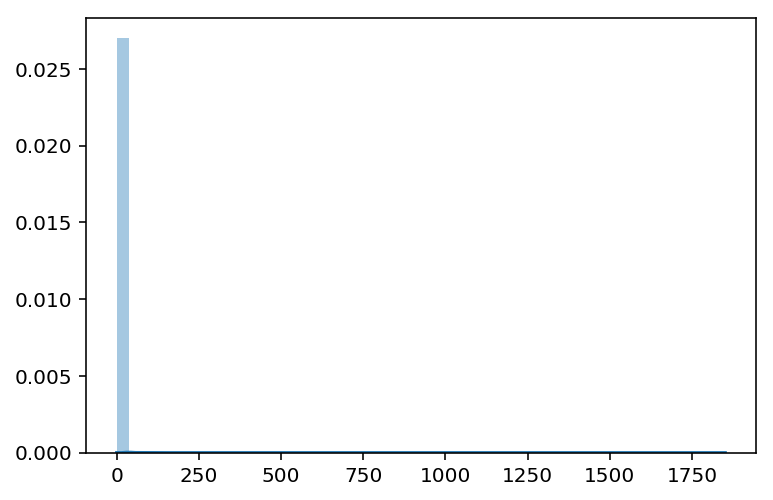

In [124]:
sns.distplot(plotData, rug=False)

In [125]:
# Min-Max Scaling
Min = min(trainScore)
Max = max(trainScore)
normScore = [(s-Min)/(Max-Min) for s in trainScore]

In [128]:
max(trainScore)

1850.9377560446953

In [ ]:
len()

In [215]:
sum([1 for i in trainScore if i < 0.03])

9231

In [165]:
nScore = [i for i in trainScore if i >= 0.03 and i <= 10 ]

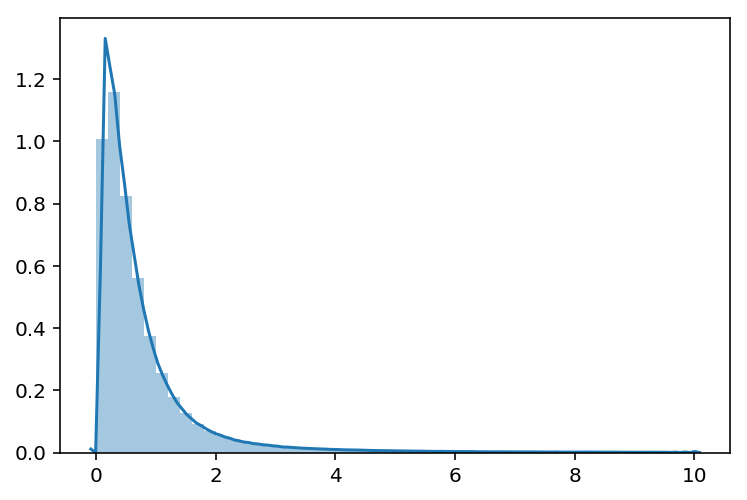

In [156]:
sns.distplot(nScore, rug=False)

In [166]:
nnScore = [(s-0.03)/(10-0.03) for s in nScore]

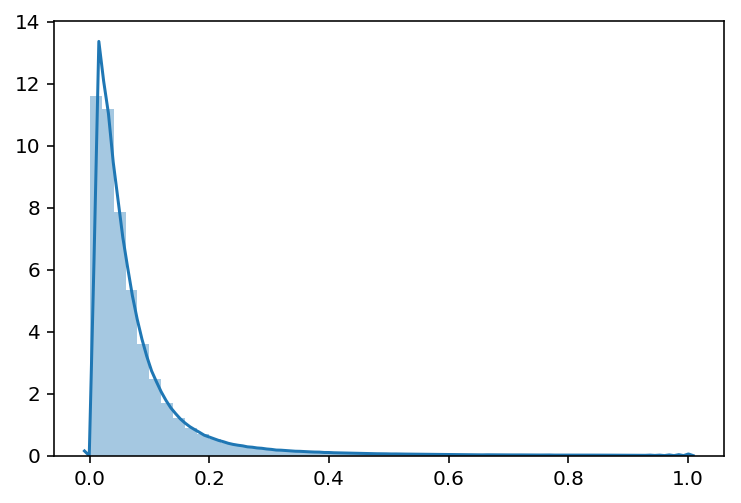

In [168]:
sns.distplot(nnScore, rug=False)

## Decison

In [229]:
Min = 0.03
Max = 10

In [233]:
newPair = []
newScore = []
for i in range(len(trainScore)):
    if trainScore[i] >= Min and trainScore[i] <= Max:
        newPair.append(trainPair[i])
        newScore.append(trainScore[i])
normScore = [(s-Min)/(Max-Min) for s in newScore]

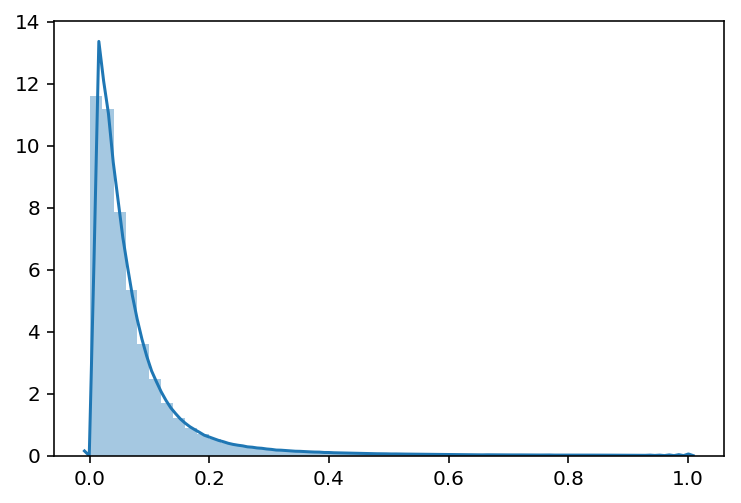

In [236]:
sns.distplot(normScore, rug=False)

In [321]:
STD = np.std(newScore)
MEAN = np.mean(newScore)

In [322]:
zScore = [(s-MEAN)/STD for s in newScore]

In [323]:
max(zScore)

9.3582915121021166

In [324]:
min(zScore)

-0.75408941425703491

### mini

In [181]:
miniCW = set([i[0] for i in sum(devcp1+devcp2+testcp1+testcp2, [])])
len(miniCW)

1769

In [182]:
miniEW = set([i[-1] for i in sum(devcp1+devcp2+testcp1+testcp2, [])])
len(miniEW)

1644

In [178]:
mini_trainPairs = []
for i in tqdm(range(len(causalPairs))):
    if causalPairs[i][0] in miniCW and causalPairs[i][1] in miniEW:
        mini_trainPairs.append(causalPairs[i])

100%|██████████| 24390169/24390169 [00:12<00:00, 1932001.88it/s]


In [183]:
mini_trainPair = []
mini_trainFreq = []
for i in tqdm(range(len(mini_trainPairs))):
    mini_trainPair.append(tuple(mini_trainPairs[i][:2]))
    mini_trainFreq.append(int(mini_trainPairs[i][-1]))

100%|██████████| 1659247/1659247 [00:02<00:00, 621495.30it/s]


In [184]:
mini_trainCword_freq = copaCword_freq
mini_trainEword_freq = copaEword_freq
mini_trainPair_freq = {mini_trainPair[i]: mini_trainFreq[i] for i in range(len(mini_trainPairs))}

In [186]:
M = 660412209
N = 62675002
ALPHA = 0.66

def mini_SPCPMI(p, LAMBDA=1.):
    """
    Compute single pair causal-PMI score
    """
    try:
        CSnec = (mini_trainPair_freq[p] / N) / (((mini_trainCword_freq[p[0]] / M) ** ALPHA) * (mini_trainEword_freq[p[1]]) / M)
    except:
        CSnec = 0
    try:
        CSsuf = (mini_trainPair_freq[p] / N) / ((mini_trainCword_freq[p[0]] / M) * ((mini_trainEword_freq[p[1]] / M) ** ALPHA))
    except:
        CSsuf = 0
        
    CS = (CSnec ** LAMBDA) * (CSsuf ** (1 - LAMBDA))
    return CS

In [187]:
mini_trainScore = [mini_SPCPMI(p) for p in tqdm(mini_trainPair)]

100%|██████████| 1659247/1659247 [00:03<00:00, 463478.86it/s]


In [188]:
mini_plotData = mini_trainScore.copy()
np.random.shuffle(mini_plotData)

In [191]:
min(mini_trainScore)

0.003001708257151525

# Build Dataset

In [328]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import h5py
import pickle

In [329]:
word2index = {copaWord[i]: i for i in range(len(copaWord))}
index2word = {i: w for w, i in word2index.items()}

In [305]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/index.pkl', 'wb') as fp:
    pickle.dump((word2index, index2word), fp, -1)

In [254]:
SEED = 42
VOCAB_SIZE = len(word2index)
EMBEDDING_DIM = 300

In [255]:
glove_n_symbols = 1917495
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, EMBEDDING_DIM))
globale_scale = 0.1
with open('/Users/lizhn7/Downloads/DATA/glove/glove.42B.300d.txt', 'r') as fp:
    index = 0
    for l in tqdm(fp):
        l = l.strip().split()
        word = l[0]
        glove_index_dict[word] = index
        glove_embedding_weights[index, :] = [float(n) for n in l[1:]]
        index += 1
glove_embedding_weights *= globale_scale

1917495it [02:51, 11208.87it/s]


In [264]:
# Generate random embedding with same scale as glove
np.random.seed(SEED)
shape = (VOCAB_SIZE, EMBEDDING_DIM)
scale = glove_embedding_weights.std() * np.sqrt(12) / 2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [265]:
# Copy from glove weights of words that appear in index2word
count = 0 
for i in tqdm(range(VOCAB_SIZE)):
    w = index2word[i]
    g = glove_index_dict.get(w)
    if g is not None:
        embedding[i, :] = glove_embedding_weights[g, :]
        count += 1
print('{num_tokens}-{per:.2f}% tokens in vocab found in glove and copied to embedding.'.format(num_tokens=count, per=count/float(VOCAB_SIZE)*100))

100%|██████████| 2793/2793 [00:00<00:00, 78909.13it/s]

2791-99.93% tokens in vocab found in glove and copied to embedding.


In [270]:
embedding[word2index['misdiagnos'], :] = glove_embedding_weights[glove_index_dict.get('misdiagnose'), :]
embedding[word2index['housegu'], :] = glove_embedding_weights[glove_index_dict.get('houseguest'), :]

In [302]:
fh = h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/embedding.h5', 'w')
fh['embedding'] = embedding
fh.close()

In [272]:
len(newPair)

1927217

In [339]:
len(zScore)

1927217

In [338]:
xCause = np.array([embedding[word2index[i[0]]] for i in tqdm(newPair)])

100%|██████████| 1927217/1927217 [00:02<00:00, 803400.12it/s]


In [341]:
xEffect = np.array([embedding[word2index[i[-1]]] for i in tqdm(newPair)])

100%|██████████| 1927217/1927217 [00:01<00:00, 975924.64it/s]


In [343]:
y = np.array([[i] for i in tqdm(zScore)])

100%|██████████| 1927217/1927217 [00:37<00:00, 51430.98it/s] 


In [344]:
y.shape

(1927217, 1)

In [345]:
xc, _ = train_test_split(xCause, test_size=0., random_state=SEED)
xe, _ = train_test_split(xEffect, test_size=0., random_state=SEED)
s, _ = train_test_split(y, test_size=0., random_state=SEED)

In [346]:
xcTrain, xcVal = train_test_split(xCause, test_size=0.15, random_state=SEED)
xeTrain, xeVal = train_test_split(xEffect, test_size=0.15, random_state=SEED)
yTrain, yVal = train_test_split(y, test_size=0.15, random_state=SEED)

In [347]:
xc.shape, xe.shape, s.shape, xcTrain.shape, xcVal.shape, xeTrain.shape, xeVal.shape, yTrain.shape, yVal.shape

((1927217, 300),
 (1927217, 300),
 (1927217, 1),
 (1638134, 300),
 (289083, 300),
 (1638134, 300),
 (289083, 300),
 (1638134, 1),
 (289083, 1))

In [348]:
fh = h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/zData.h5', 'w')
fh['xc'] = xc 
fh['xe'] = xe
fh['s'] = s
fh['xcTrain'] = xcTrain
fh['xcVal'] = xcVal
fh['xeTrain'] = xeTrain
fh['xeVal'] = xeVal
fh['yTrain'] = yTrain
fh['yVal'] = yVal
fh.close()